# Attribution methods

In this notebook I perform attribution methods with the Wts and check for correlation with the sign distributions.

In [1]:
# imports

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

2024-06-08 15:25:23.018059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN2Model_adapted(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model_adapted, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    #@tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        dense1_input = self.flatten(x)
        dense1_out = self.dense1(dense1_input)
        dense2_out = self.dense2(dense1_out)
        dense3_out = self.dense3(dense2_out)
        return dense3_out, dense1_out[0], dense2_out[0]

100%|██████████| 10000/10000 [57:29<00:00,  2.90it/s]


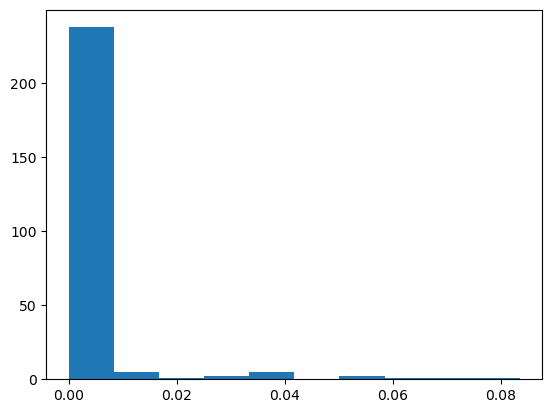

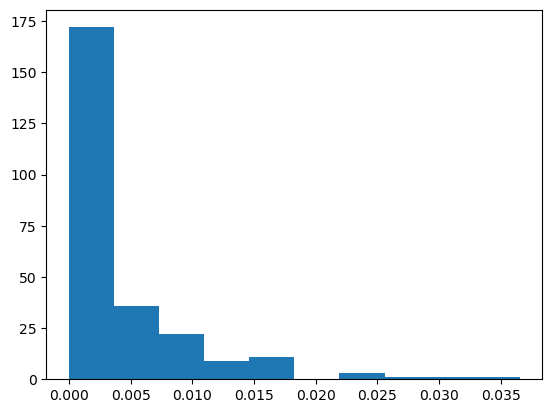

In [4]:
# get contribution values for neurons
def contribution_scores(test, model):

    # hyperparameters
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializeing contribution scores
    c_score_1 = np.zeros(256)
    c_score_2 = np.zeros(256)

    # iterate through testing set and get gradients for each weight
    first_round = True
    for x, t in tqdm(test):

        # get gradients 
        with tf.GradientTape() as tape:
            pred, dense1_out, dense2_out = model(x)
            loss = loss_function(t, pred)
        gradients = tape.gradient(loss, model.trainable_variables)

        # set gradients to zero for all pruned weights
        new_gradients = []
        for gradient_matrix, variables in zip(gradients, model.trainable_variables):
            gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
            new_gradients.append(gradient_matrix)
        gradients_dense2 = new_gradients[6]
        gradients_dense3 = new_gradients[8]

        # compute c score for each neuron
        for i in range(256):
            c_score_1[i] = c_score_1[i] + np.sum(np.abs(gradients_dense2[i]*dense1_out[i]))
            c_score_2[i] = c_score_2[i] + np.sum(np.abs(gradients_dense3[i]*dense2_out[i]))

    # normalize c_scores to values between 0 and 1
    c_score_1 = c_score_1 / np.sum(c_score_1)
    c_score_2 = c_score_2 / np.sum(c_score_2)
    
    return  c_score_1,c_score_2

In [3]:
def try_computing_c_scores():

    # make a model to load the weights into
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=1, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])
    weights_wt = model.get_weights()
    #print(weights_wt[0][0][0][0])
    
    # get WT weights
    #model.load_weights(f"1b WTs/old_format/WT_CIFAR_IMP_0") # does not work for thesis env, works for no_gpu, does not work for gpu
    #model.load_weights(f"1b WTs/new_format/WT_CIFAR_IMP_0.weights.h5") # does not work for thesis env, works for no_gpu, does not work for gpu
    model.load_weights(f"1b WTs/h5_format/WT_CIFAR_IMP_0.h5") # does work for thesis env, works for no_gpu, works for gpu     
    weights_wt = model.get_weights()
    #print(weights_wt[0][0][0][0])

    # plot distirbution of contribution values
    for c_score in contribution_scores(test_dataset, model):
        #print(c_score)
        plt.figure()
        plt.hist(c_score)
        plt.show()

#try_computing_c_scores()

2024-06-08 15:25:27.389196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 15:25:27.439590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 15:25:27.439783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[ 0.00650881 -0.02182875  0.03089781 -0.08985776  0.02500349 -0.07537685
  0.03774495 -0.00285682 -0.04449913 -0.03845106  0.01698214  0.03447889
  0.00600125  0.00074863  0.03564246  0.06237182 -0.01488221 -0.05054392
 -0.00582335  0.01778994  0.04295386 -0.07842498 -0.0834002  -0.026866
 -0.05042389 -0.07521044  0.02440945 -0.00088095  0.08087108 -0.07992527
  0.00753598  0.05888757 -0.07822406 -0.03056831 -0.01207802 -0.05326547
  0.02379467  0.01805939 -0.07509857  0.01613484  0.030192   -0.03046131
 -0.07178821 -0.01681533  0.00511863 -0.07085908  0.09932216  0.08581939
 -0.02858925  0.09308875 -0.05295458 -0.08716218  0.01173261 -0.08989063
 -0.0780398   0.00710951  0.08889468  0.02663618  0.08576076 -0.06073443
  0.01549752 -0.05627536 -0.00622302 -0.05799176]
[ 0.         -0.08607975  0.          0.          0.          0.
  0.          0.05689463  0.          0.         -0.09360019  0.
  0.          0.          0.          0.04675482  0.          0.
  0.          0.          0

In [ ]:
# store contribution values for each sign distribution in files
def get_and_store_c_scores():
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=2, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])

    for dataset in ["CIFAR","CINIC","SVHN"]:
        coll_c_scores_1 = []
        coll_c_scores_2 = []
        for i in range(15):
            train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=1, shuffle_size=512)
            model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")
            c_scores_1, c_scores_2 = contribution_scores(test_dataset, model)
            coll_c_scores_1.append(c_scores_1)
            coll_c_scores_2.append(c_scores_2)
        np.save(f"5d Contribution values/c_scores_dense1_{dataset}", np.array(coll_c_scores_1))
        np.save(f"5d Contribution values/c_scores_dense2_{dataset}", np.array(coll_c_scores_2))

In [5]:
# plot contribution values in scatterplot matrix as 5th dimension

In [6]:
# collect statistics for contribution value of each cluster